In [1]:
import os
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib as mpl
mpl.rc("figure", figsize=(10, 10))
mpl.rcParams.update({'font.size': 10})
import matplotlib.pyplot as plt
os.environ["PROJ_LIB"] = "C:\\Utilities\\Python\\Anaconda\\Library\\share"
from mpl_toolkits.basemap import Basemap
from src.plotting_functions import pcolormesh_basemapplot_cube
from src.plotting_functions import pcolormesh_basemapplot_data
from src.plotting_functions import pcolormesh_df
from src.plotting_functions import plot_locations_df
from src.plotting_functions import histogram_plot
from src.plotting_functions import bernoulli_gamma_pdf_plot
from src.plotting_functions import plot_observations_df
from src.plotting_functions import lima_alpha_beta_relationship_scatter

base_path = '/data/notebooks/jupyterlab-biascorrlab/data/Lima2021/'
folder = 'Randomly_Distributed_Observations_100/'

2022-05-17 13:05:08.384112: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
#Converting posterior samples output from fitting Bernoulli-Gamma model using MCMC (see bg_lima.py) to xarray dataset
mcmc_samples_obj = np.load(f'{base_path}{folder}AP_BGLima_Snowfall_044_Sample.npy',allow_pickle=True)
mcmc_samples_dict = dict(zip(mcmc_samples_obj[:,0], mcmc_samples_obj[:,1]))

parameters = ['p','alpha','beta']
hyper_parameters = ['a0','a1','betavar']
param_dims = ['samples','months','sites']
hparam_dims = ['samples']

params_dict = dict(zip(parameters,[{"dims":param_dims,"data":mcmc_samples_dict[param]} for param in parameters]))
hparams_dict = dict(zip(hyper_parameters,[{"dims":hparam_dims,"data":mcmc_samples_dict[hparam]} for hparam in hyper_parameters]))

ds_params = xr.Dataset.from_dict(params_dict)
ds_hparams = xr.Dataset.from_dict(hparams_dict)

In [11]:
#Mean parameter summary statistics across all sites for January
ds_params.mean(dim='samples').isel(months=0).to_dataframe().describe()

,p,alpha,beta
count,100.000000,100.000000,100.000000
mean,0.588816,0.756645,0.397963
std,0.137607,0.100422,0.206570
min,0.206430,0.552586,0.098326
25%,0.523649,0.688844,0.224372
50%,0.632013,0.746317,0.374454
75%,0.680053,0.850991,0.528177
max,0.811553,1.003084,1.199605


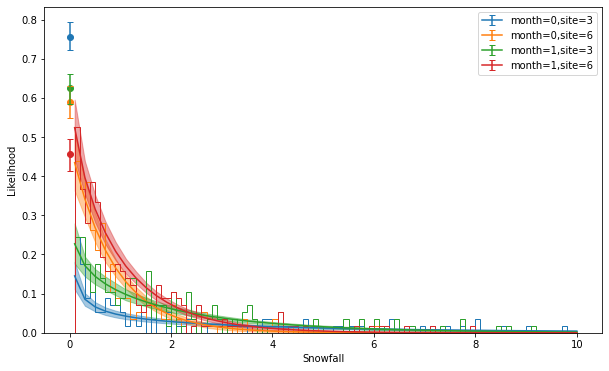

In [35]:
#Example of PDFs estimated from BG fit agaist empirical PDFs
site_index_min_alpha = ds_params['alpha'].mean(dim='samples').isel(months=0).argmin().values
site_index_max_alpha = ds_params['alpha'].mean(dim='samples').isel(months=0).argmax().values
months = [0,1]
sites = [site_index_min_alpha,site_index_max_alpha]
bounds = [0.1,10]
figure = plt.figure(figsize=(10,6))
histogram_plot(data,months,sites,bounds,0.1)
plt.gca().set_prop_cycle(None)
bernoulli_gamma_pdf_plot(mcmc_samples_dict,months,sites,bounds)
plt.xlabel("Snowfall")
plt.ylabel("Likelihood")
plt.legend()

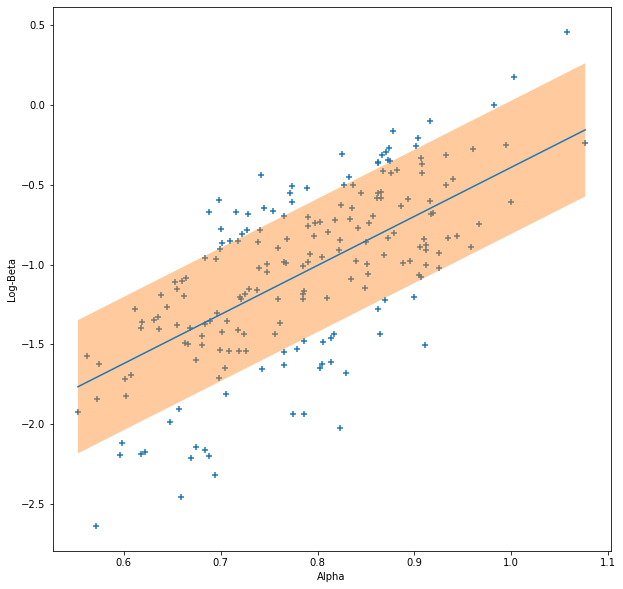

In [36]:
#Plotting empirical and modelled relationship between alpha and log-beta 
figure = plt.figure(figsize=(10,10))
lima_alpha_beta_relationship_scatter(mcmc_samples_dict)

Text(0.5, 0, 'Parameter Value')

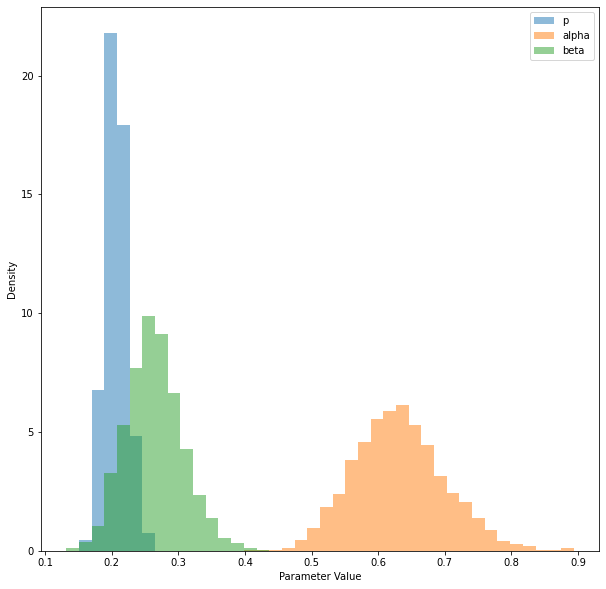

In [44]:
#Example of posterior PDFs for parameters for a given month and site
ds_params.isel(months=0,sites=0).to_dataframe().plot.hist(bins=40,alpha=0.5,density=True)
plt.ylabel('Density')
plt.xlabel('Parameter Value')

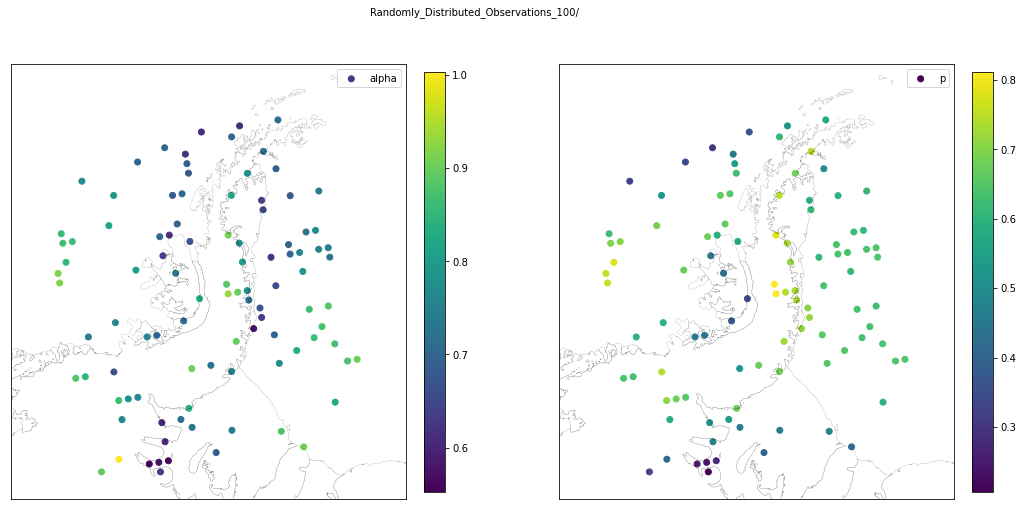

In [45]:
df = pd.read_csv(f'{base_path}{folder}AP_BGLima_Snowfall_044_Mean_Estimates.csv',index_col=0) 
df = df[df['month']==1]

fig, axs = plt.subplots(1,2,figsize=(18,8))
antarctica_peninsula_map = Basemap(width=2000000,height=2200000,projection='laea',lat_ts=-55,lat_0=-71,lon_0=-67,resolution='l')
parameters = ['alpha','p']
for i in np.arange(0,len(parameters),1):
    param = parameters[i]
    plt.subplot(1,2,i+1)
    plot_observations_df(df,antarctica_peninsula_map,param,f'{param}')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.legend()
plt.suptitle(f'{folder}',fontsize=10,color='k')
plt.show()